In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , Adamax
# from tensorflow.keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
data_paths = ['/kaggle/input/tomato/train', '/kaggle/input/tomato/valid']

def create_dataframe(data_paths):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # Iterate through each provided data path
    for data_path in data_paths:
        # List all subfolders in the current data path
        folds = os.listdir(data_path)
        
        # Iterate through each subfolder (class folder)
        for fold in folds:
            f_path = os.path.join(data_path, fold)
            if not os.path.isdir(f_path):  # Skip any non-directory files
                continue
            imgs = os.listdir(f_path)
            
            # Iterate through images in the subfolder
            for img in imgs:
                img_path = os.path.join(f_path, img)
                
                # Append image path and corresponding label
                filepaths.append(img_path)
                labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data_paths)

In [6]:
df.head()

,Filepaths,Labels
0,/kaggle/input/tomato/train/Late_blight/LB_ (13...,Late_blight
1,/kaggle/input/tomato/train/Late_blight/781e93a...,Late_blight
2,/kaggle/input/tomato/train/Late_blight/1e0c01b...,Late_blight
3,/kaggle/input/tomato/train/Late_blight/110822-...,Late_blight
4,/kaggle/input/tomato/train/Late_blight/283ff0b...,Late_blight


In [7]:
df.shape

(32534, 2)

In [8]:
print("The classes:\n", np.unique(df['Labels']))


The classes:
 ['Bacterial_spot' 'Early_blight' 'Late_blight' 'Leaf_Mold'
 'Septoria_leaf_spot' 'Spider_mites Two-spotted_spider_mite' 'Target_Spot'
 'Tomato_Yellow_Leaf_Curl_Virus' 'Tomato_mosaic_virus' 'healthy'
 'powdery_mildew']


In [9]:
# Count the number of images in each class
class_counts = df['Labels'].value_counts()
class_counts

Labels
Late_blight                             3905
healthy                                 3856
Septoria_leaf_spot                      3628
Bacterial_spot                          3558
Leaf_Mold                               3493
Early_blight                            3098
Tomato_mosaic_virus                     2737
Tomato_Yellow_Leaf_Curl_Virus           2537
Target_Spot                             2284
Spider_mites Two-spotted_spider_mite    2182
powdery_mildew                          1256
Name: count, dtype: int64

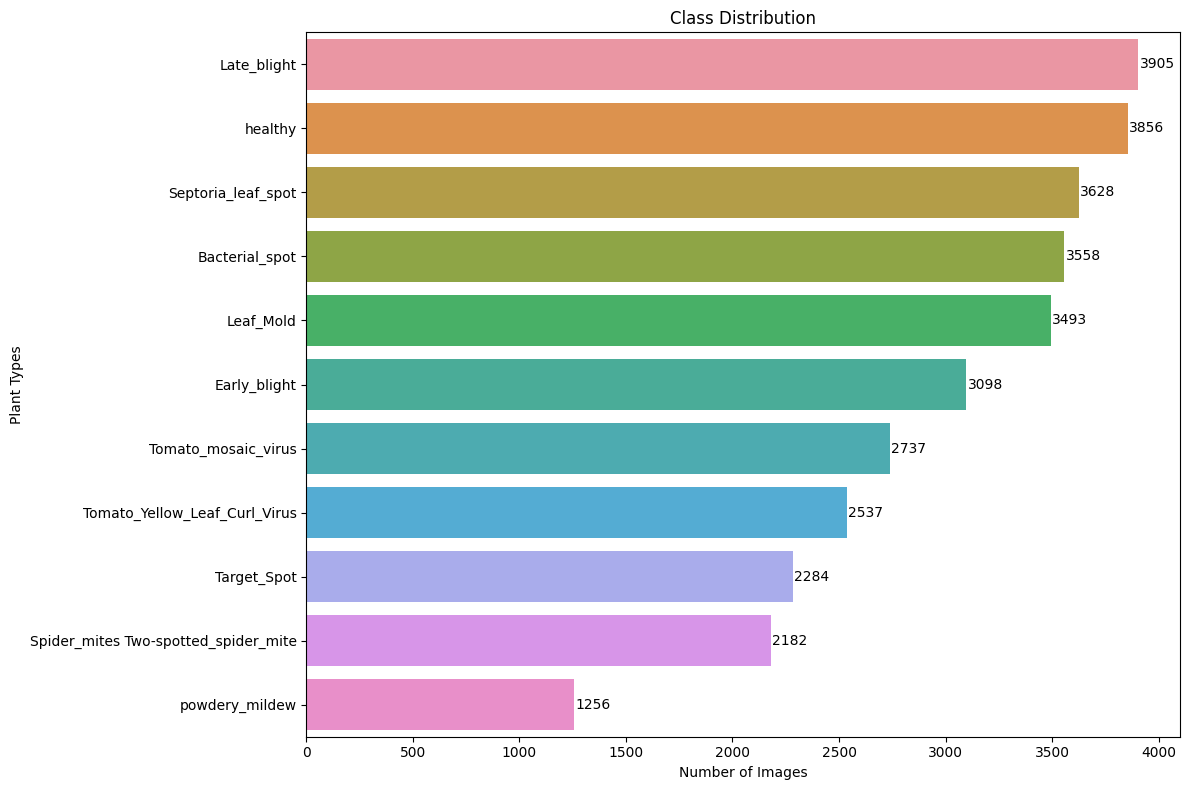

In [10]:
# Visualize class distribution using a horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_counts.values, y=class_counts.index, orient='h')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels

# Add data labels to each bar
for i, v in enumerate(class_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

In [11]:
# Perform data reduction to 1200 samples per class
df_reduced = df.groupby('Labels').apply(lambda x: x.sample(n=1200, random_state=42)).reset_index(drop=True)

<ipython-input-11-2e02ab3831a0>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df.groupby('Labels').apply(lambda x: x.sample(n=1200, random_state=42)).reset_index(drop=True)


In [12]:
df_reduced.shape

(13200, 2)

In [13]:
# Get reduced class counts
class_counts_reduced = df_reduced['Labels'].value_counts()
class_counts_reduced

Labels
Bacterial_spot                          1200
Early_blight                            1200
Late_blight                             1200
Leaf_Mold                               1200
Septoria_leaf_spot                      1200
Spider_mites Two-spotted_spider_mite    1200
Target_Spot                             1200
Tomato_Yellow_Leaf_Curl_Virus           1200
Tomato_mosaic_virus                     1200
healthy                                 1200
powdery_mildew                          1200
Name: count, dtype: int64

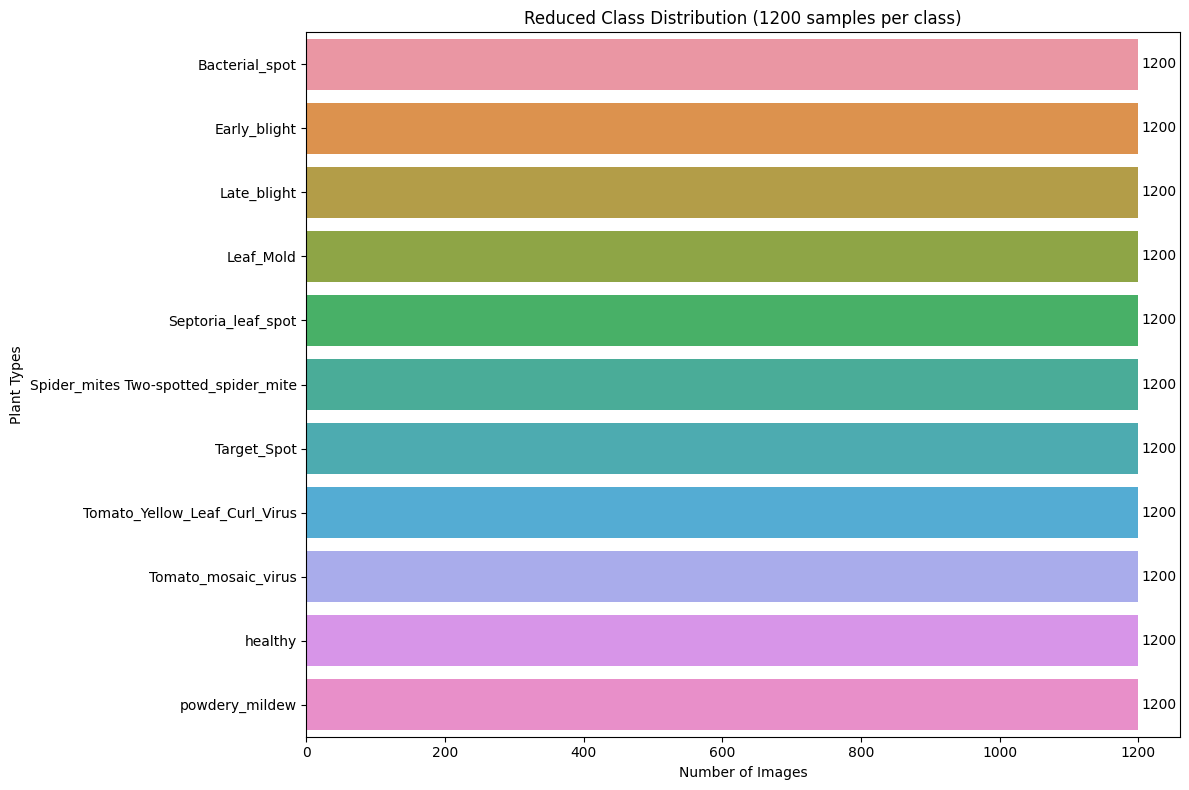

In [14]:
# Visualize reduced class distribution
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_counts_reduced.values, 
                 y=class_counts_reduced.index, 
                 orient='h')
plt.title('Reduced Class Distribution (1200 samples per class)')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()

# Add data labels
for i, v in enumerate(class_counts_reduced.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()